In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch import nn
import torch.nn.functional as F
# from sklearn.metrics import roc_curve, auc
from torch.autograd import Variable
plt.rcParams.update({'font.size': 15})
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from scipy.optimize import minimize
from scipy import signal
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
import geatpy as ea

In [2]:
with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/output/L5PC__passiveDendrites__AMPA_GABA_A/sub.p', 'rb') as fo:
    data = pickle.load(fo, encoding='bytes')

In [3]:
X_train = np.empty([10, 1278, 1000])
Y_train = np.empty([10, 1000])
for i in range(len(data['Results']['listOfSingleSimulationDicts'])):
    X_train[i][:639, :] = data['Results']['listOfSingleSimulationDicts'][i]['inputSpikeTrains_ex']
    X_train[i][639:, :] = data['Results']['listOfSingleSimulationDicts'][i]['inputSpikeTrains_inh']
    Y_train[i] = data['Results']['listOfSingleSimulationDicts'][i]['somaVoltageLowRes']

In [4]:
Y_train_ori = Y_train.copy()
# Y_test_ori = Y_test.copy()

In [5]:
# thresholding
threshold = -58
Y_train[Y_train > threshold] = threshold

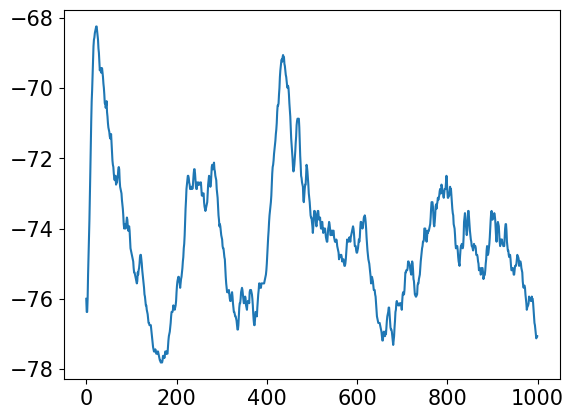

In [6]:
plt.plot(Y_train[2])

In [7]:
# pre-processing
## standardization
Y_train_std = np.empty_like(Y_train)
# Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
# Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

# X_train_std = list2array(X_train)
# X_test_std = list2array(X_test)
X_train_std = X_train

## from numpy to pytorch
Y_train_std = torch.tensor(Y_train_std).to(device)
Y_train_std = Y_train_std.to(torch.float32)

# Y_test_std = torch.tensor(Y_test_std).to(device)
# Y_test_std = Y_test_std.to(torch.float32)

X_train_std = torch.tensor(X_train_std).to(device)
X_train_std = X_train_std.to(torch.float32)

# X_test_std = torch.tensor(X_test_std).to(device)
# X_test_std = X_test_std.to(torch.float32)

In [8]:
train = Variable(X_train_std)

In [9]:
def kernel(time_dur, tau_rise, tau_decay):
    T = torch.arange(time_dur).to(device)
    y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
    return torch.flip(y, dims=[0])

def Kernel(time_dur, in_channels, Tau_rise, Tau_decay):
    y = torch.empty(1, in_channels, time_dur)
    for i in range(in_channels):
        y[0, i] = kernel(time_dur, Tau_rise[i], Tau_decay[i])
    return y.to(device)

In [10]:
class model_l(nn.Module):
    def __init__(self, time_dur, in_channels):
        super(model_l, self).__init__()
        self.time_dur = time_dur
        self.in_channels = in_channels
        weight = torch.cat((torch.ones((1, 639, 1), requires_grad=True) * 0.02, torch.ones((1, 639, 1), requires_grad=True) * -0.02), dim=1)
        self.weight = nn.Parameter(weight)
        # Tau_rise = torch.ones(1278, requires_grad=True) * 2
        Tau_rise = torch.rand((1278), requires_grad=True) * 5 + 1
        # Tau_rise = torch.cat((torch.tensor(([0.1, 1.]*319), requires_grad=True), torch.ones(640, requires_grad=True)*0.1), dim=0)
        self.Tau_rise = nn.Parameter(Tau_rise)
        # Tau_decay = torch.ones(1278, requires_grad=True) * 8
        Tau_decay = torch.rand((1278), requires_grad=True) * 10 + 7
        # Tau_decay = torch.cat((torch.tensor(([1., 9.]*319), requires_grad=True), torch.ones(640, requires_grad=True)*1), dim=0)
        self.Tau_decay = nn.Parameter(Tau_decay)
        bias = torch.ones(1, requires_grad=True) * -2
        self.bias = nn.Parameter(bias)

    def forward(self, x):
        filter = Kernel(time_dur=self.time_dur, in_channels=self.in_channels, Tau_rise=self.Tau_rise, Tau_decay=self.Tau_decay) * self.weight
        x = F.conv1d(x, filter, padding=self.time_dur-1, bias=self.bias)
        x = torch.squeeze(x)[:, :self.time_dur]
        return x

In [12]:
N_sample = X_train_std.shape[0]
in_channels = X_train_std.shape[1]
time_dur = X_train_std.shape[2]
net = model_l(time_dur, in_channels)
net.to(device)
error = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

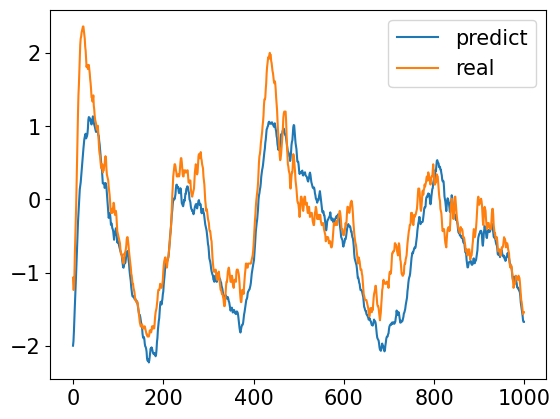

In [14]:
idx = 2
output = net(train)
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()

In [13]:
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
output = net(train)
error(output, tr_labels)

tensor(0.5567, device='cuda:7', grad_fn=<MseLossBackward0>)

In [15]:
# ANN model training
num_epochs = 500
loss_train_list = []
iteration_list = []
loss_test_list = []
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
# test = Variable(X_test_std)
# test_labels = Variable(Y_test_std)
# mask_tr = spike_time_mask(tr_spike_time)
# mask_tr = mask_tr.to(device)
# mask_test = spike_time_mask(test_spike_time)
# mask_test = mask_test.to(device)
for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels)
    #loss_train = error_mask(outputs, tr_labels, mask_tr) # Calculate loss
    loss_train.backward() # Calculating gradients
    #loss_train.backward(retain_graph=True) 
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 100 == 0:        
        # Predict test dataset
        #outputs = net(test) # Forward propagation
        #loss_test = error(outputs, test_labels)
        #loss_test = error_mask(outputs, test_labels, mask_test)
        # store loss and iteration
        loss_train_list.append(loss_train.data.item())
        iteration_list.append(epoch)
        #loss_test_list.append(loss_test.data.item())
    if epoch % 100 == 0:
        print('Iteration: {}  Train_Loss: {}  '.format(epoch, loss_train.data.item()))
print('Final: Train_Loss: {}  '.format(loss_train.data.item()))

Iteration: 0  Train_Loss: 0.5566552877426147  
Iteration: 100  Train_Loss: 0.10288705676794052  
Iteration: 200  Train_Loss: 0.06344930082559586  
Iteration: 300  Train_Loss: 0.047645434737205505  
Iteration: 400  Train_Loss: 0.039221879094839096  
Final: Train_Loss: 0.03400970250368118  


In [16]:
output = net(train)
for i in range(10):
    print(torch.sum((output[i]-Y_train_std[i])**2) / torch.sum((torch.mean(Y_train_std[i])-Y_train_std[i])**2))

tensor(0.0406, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0431, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0411, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0543, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0250, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0570, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1317, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0720, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0477, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0229, device='cuda:7', grad_fn=<DivBackward0>)


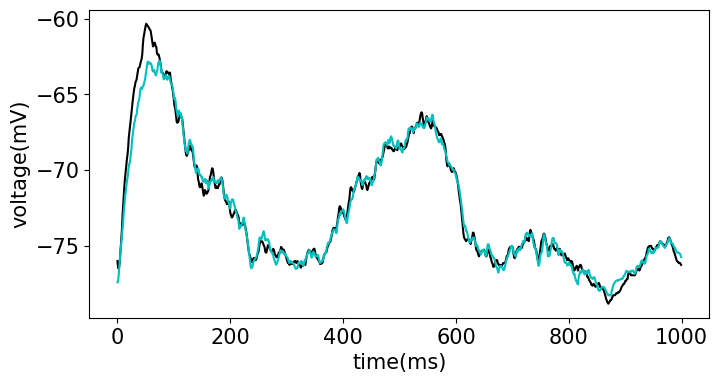

In [19]:
idx = 9
y = output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train)
plt.figure(figsize=(8,4))
plt.xlabel('time(ms)')
plt.ylabel('voltage(mV)')
plt.plot(Y_train_ori[idx], color='black', label='real')
plt.plot(y, color='c', label='predict')

In [20]:
tau_rise_vec = net.Tau_rise.cpu().detach().numpy()[:639]
tau_decay_vec = net.Tau_decay.cpu().detach().numpy()[:639]

In [21]:
def create_single_PSP_kernel(tau_rise, tau_decay, temporal_filter_length):

    exp_r = signal.exponential(M=temporal_filter_length, center=0, tau=tau_rise , sym=False)
    exp_d = signal.exponential(M=temporal_filter_length, center=0, tau=tau_decay, sym=False)

    post_syn_potential = exp_d - exp_r
    post_syn_potential /= post_syn_potential.max()

    return post_syn_potential

def construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, time_dur):

    num_synapses = tau_rise_vec.shape[0]
    # temporal_filter_length = int(4 * tau_decay_vec.max()) + 1
    temporal_filter_length = time_dur

    syn_filter = np.zeros((num_synapses, temporal_filter_length))

    for k, (tau_r, tau_d) in enumerate(zip(tau_rise_vec, tau_decay_vec)):
        syn_filter[k,:] = create_single_PSP_kernel(tau_r, tau_d, temporal_filter_length=time_dur)

    return syn_filter

In [22]:
len(np.where(tau_rise_vec>tau_decay_vec)[0])

0

In [32]:
syn_filter = construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, 1000)

In [24]:
syn_filter.shape

(639, 1000)

In [25]:
# syn_filter = syn_filter[:, :120]

Text(0.5, 1.0, 'normalized kernel')

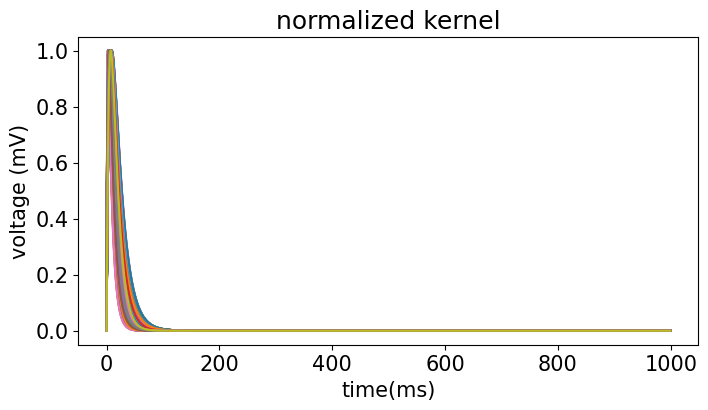

In [33]:
plt.figure(figsize=(8,4))
plt.plot(syn_filter.T)
plt.xlabel('time(ms)')
plt.ylabel('voltage (mV)')
plt.title('normalized kernel')
# plt.savefig('figure/normalized_kernel', bbox_inches='tight')

In [34]:
X = syn_filter
PSP_SVD_model = TruncatedSVD(n_components=100)
PSP_SVD_model.fit(X)

SVD_cutoff_ind = 3
max_SVD_basis_to_present = 18

Text(0.5, 0, 'index of singular vectors')

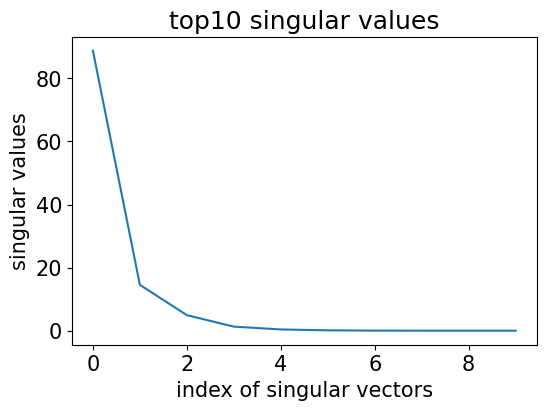

In [35]:
plt.figure(figsize=(6,4))
plt.plot(PSP_SVD_model.singular_values_[:10])
plt.title('top10 singular values')
plt.ylabel('singular values')
plt.xlabel('index of singular vectors')
# plt.savefig('figure/kernel_singular_value_top10', bbox_inches='tight')

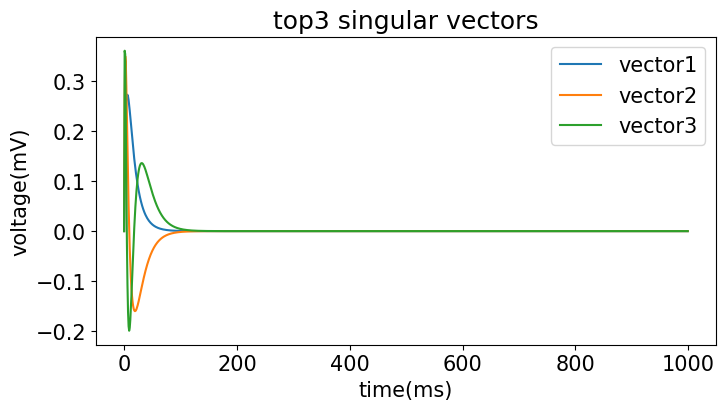

In [36]:
plt.figure(figsize=(8,4))
plt.plot(PSP_SVD_model.components_[0].T, label='vector1')
plt.plot(-PSP_SVD_model.components_[1].T, label='vector2')
plt.plot(PSP_SVD_model.components_[2].T, label='vector3')
plt.title('top3 singular vectors')
plt.xlabel('time(ms)')
plt.ylabel('voltage(mV)')
plt.legend()
# plt.savefig('figure/kernel_singular_vector_top3', bbox_inches='tight')

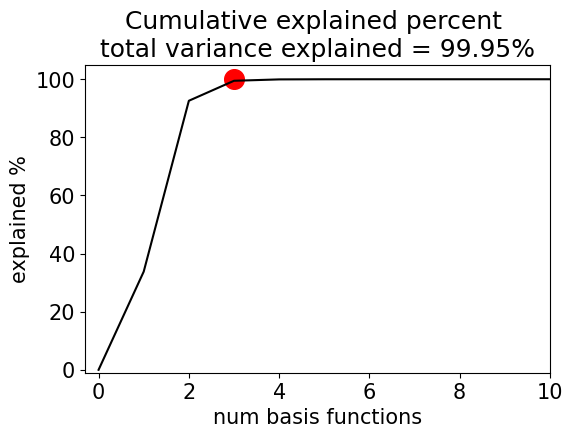

In [31]:
num_basis_functions = PSP_SVD_model.explained_variance_ratio_.shape[0]
explained_var_percent = 100 * PSP_SVD_model.explained_variance_ratio_
cumsum_explained_var_percent = np.concatenate((np.array([0]), np.cumsum(explained_var_percent)))
dot_selected_ind = 3
plt.close('all')
plt.figure(figsize=(6,4));
plt.plot(np.arange(num_basis_functions + 1), cumsum_explained_var_percent, c='k')
plt.scatter(dot_selected_ind, cumsum_explained_var_percent[dot_selected_ind+1], c='r', s=200)
plt.xlabel('num basis functions'); plt.ylabel('explained %s' %('%')); 
plt.title('Cumulative explained percent \ntotal variance explained = %.2f%s' %(cumsum_explained_var_percent[dot_selected_ind+1],'%'));
plt.ylim(-1,105); plt.xlim(-1,num_basis_functions+1); plt.xlim(-0.3,10);
# plt.savefig('figure/kernel_cumulative_VE', bbox_inches='tight')

In [37]:
x1 = PSP_SVD_model.components_[0]
x2 = -PSP_SVD_model.components_[1]
x3 = PSP_SVD_model.components_[2]

In [39]:
vec = torch.zeros((3, 1000))
vec[0] = torch.flip(torch.tensor(x1), dims=[0])
vec[1] = torch.flip(torch.tensor(x2), dims=[0])
vec[2] = torch.flip(torch.tensor(x3), dims=[0])

In [41]:
vec = vec.repeat(639*2, 1)

In [54]:
vec.size()

torch.Size([3834, 1000])

In [45]:
all_vec = torch.zeros((1, 639*6, 1000))
all_vec[0] = vec

In [46]:
X_train_svd = torch.zeros(10, 1278*3, 1000)
for i in range(1278):
    X_train_svd[:, 3*i, :] = X_train_std[:, i, :]
    X_train_svd[:, 3*i+1, :] = X_train_std[:, i, :]
    X_train_svd[:, 3*i+2, :] = X_train_std[:, i, :]

In [ ]:
X_train_svd[0][0] = X_train_svd.reshape(10, 639*6, 1000)

In [50]:
x =  F.conv1d(X_train_svd, all_vec, padding=999, bias=torch.tensor([0.0]))
x = torch.squeeze(x)[:, :1000]

In [53]:
x.size()

torch.Size([10, 1000])

In [87]:
kernel0 = torch.zeros((1, 1, 1000))
kernel0[0, 0] = vec[0]
x = torch.zeros((1, 1, 1000))
x[0][0][0] = 1
x[0][0][100] = 1
# x[0][0] = X_train_std[0][0]

In [92]:
conv1 = nn.Conv1d(1, 1, kernel_size=1000, padding=999, bias=False)
conv1.weight.data = kernel2

In [93]:
y = conv1(x)[0, 0, :1000]

In [94]:
y.size()

torch.Size([1000])

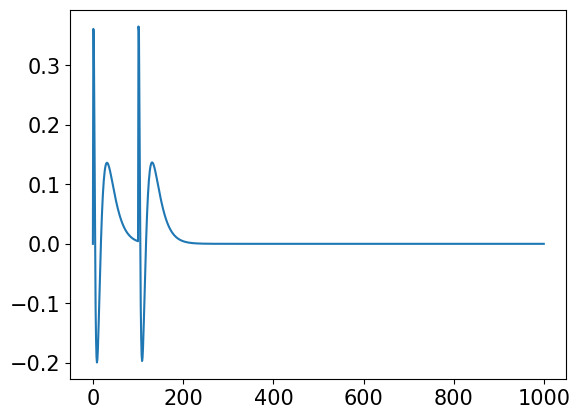

In [95]:
plt.plot(y.detach().numpy())

In [86]:
kernel0 = torch.zeros((1, 1, 1000))
kernel0[0, 0] = vec[0]
kernel1 = torch.zeros((1, 1, 1000))
kernel1[0, 0] = vec[1]
kernel2 = torch.zeros((1, 1, 1000))
kernel2[0, 0] = vec[2]

In [122]:
X = torch.zeros((3*1278, 1000))
kernel = torch.zeros((1, 1, 1000))
x = torch.zeros((1, 1, 1000))
for i in range(3):
    for j in range(1278):
        kernel[0, 0] = vec[i]
        x[0][0] = X_train_std[0][j]
        conv1 = nn.Conv1d(1, 1, kernel_size=1000, padding=999, bias=False)
        conv1.weight.data = kernel
        y = conv1(x)[0, 0, :1000]
        X[3*j+i] = y

In [108]:
X.size()

torch.Size([3834, 1000])

In [110]:
omega = torch.inverse(torch.matmul(X, X.T))@X@Y_train_std.cpu()[0]

In [111]:
omega.size()

torch.Size([3834])

In [113]:
from sklearn.linear_model import LinearRegression

In [123]:
X = X.T.detach().numpy()
X.shape

(1000, 3834)

In [124]:
y = Y_train_std.cpu().detach().numpy()[0]
y.shape

(1000,)

In [125]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9999999999950643

In [128]:
omega = reg.coef_
omega.shape
intercept = reg.intercept_

In [129]:
output = X@omega + intercept

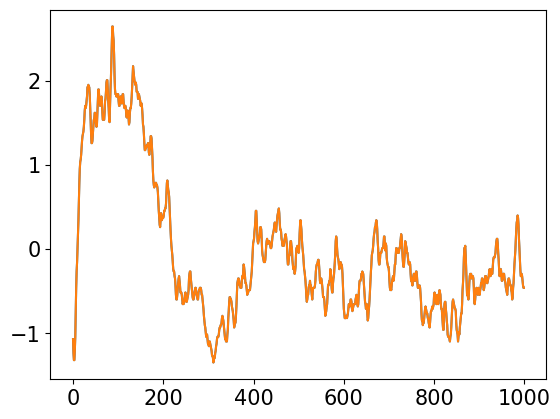

In [131]:
plt.plot(output)
plt.plot(Y_train_std.cpu().detach().numpy()[0])

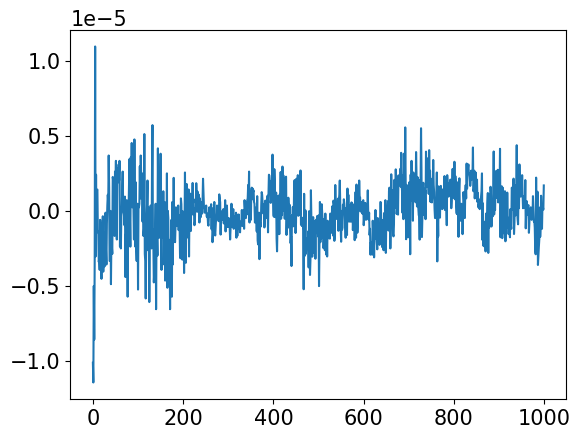

In [132]:
plt.plot(output-Y_train_std.cpu().detach().numpy()[0])